In [1]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import hickle as hkl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.manifold
import copy
import csv
import __main__ as main
import argparse
import pandas as pd
from tabulate import tabulate
import time

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

2024-01-12 10:51:24.467829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-12 10:51:28.216834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-01-12 10:51:28.216972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-01-12 10:51:28.216994: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
# Library scripts
import utils 
import training
import data2vec_model
import mae_model
import simclr_model

In [3]:
experimentSetting = 'LODO'
# 'LOGO','LODO'
testingDataset = 'HHAR'
# 'HHAR','MobiAct','MotionSense','RealWorld_Waist','UCI','PAMAP'
evaluationType = 'group'
# 'subject','group'

method = 'MAE'
# Data2vec, MAE, SimCLR

architecture = 'HART'

finetune_epoch = 1

finetune_batch_size = 64

SSL_batch_size = 128

loss = 'Adam'
# 'LARS', 'Adam', 'SGD'

SSL_LR = 3e-4

FT_LR = 3e-4

input_shape = (128,6)

frame_length = 16

SSL_epochs = 1

masking_ratio = 75e-2

instance_number = 0

randomRuns = 5

In [4]:
datasets = ['HHAR','MobiAct','MotionSense','RealWorld_Waist','UCI','PAMAP']

In [5]:
datasets = ['MobiAct','MotionSense','UCI','PAMAP','SHL']

In [6]:
architectures = ['HART','ISPL']

In [7]:
def add_fit_args(parser):
    """
    parser : argparse.ArgumentParser
    return a parser added with args required by fit
    """
    # Training settings
    parser.add_argument('--experimentSetting', type=str, default=experimentSetting, 
        help='Leave one dataset out or Leave one group out')  
    parser.add_argument('--testingDataset', type=str, default=testingDataset, 
        help='Left out dataset')  
    parser.add_argument('--evaluationType', type=str, default=evaluationType, 
        help='Dataset group evaluation or subject by subject evaluation')  
    parser.add_argument('--SSL_epochs', type=int, default=SSL_epochs, 
        help='SSL Epochs')  
    parser.add_argument('--SSL_batch_size', type=int, default=SSL_batch_size, 
        help='SSL batch_size')  
    parser.add_argument('--finetune_epoch', type=int, default=finetune_epoch, 
        help='Fine_tune Epochs')  
    parser.add_argument('--loss', type=str, default=loss, 
        help='Specify the loss') 
    parser.add_argument('--SSL_LR', type=float, default=SSL_LR, 
        help='Specify the learning rate for the SSL techniques') 
    parser.add_argument('--masking_ratio', type=float, default=masking_ratio, 
        help='Specify the masking ratio') 
    parser.add_argument('--frame_length', type=int, default=frame_length, 
        help='Specify the masking ratio') 
    parser.add_argument('--architecture', type=str, default=architecture, 
        help='Specify the architecture of the model to train with') 
    parser.add_argument('--method', type=str, default=method, 
        help='Specify the SSL method') 
    parser.add_argument('--instance_number', type=int, default=instance_number, 
        help='Specify the SSL method') 
    args = parser.parse_args()
    return args
def is_interactive():
    return not hasattr(main, '__file__')

In [8]:
tf.keras.backend.set_floatx('float32')
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
if(input_shape[0] % frame_length != 0 ):
    raise Exception("Invalid segment size")
else:
    patch_count = input_shape[0] // frame_length
print("Number of segments : "+str(patch_count))

Number of segments : 8


In [10]:
rootdir = './'
if not is_interactive():
    args = add_fit_args(argparse.ArgumentParser(description='SSL Pretraining Pipeline'))
    experimentSetting = args.experimentSetting
    testingDataset = args.testingDataset
    evaluationType = args.evaluationType
    SSL_epochs = args.SSL_epochs
    frame_length = args.frame_length
    SSL_batch_size = args.SSL_batch_size
    finetune_epoch = args.finetune_epoch
    loss = args.loss
    SSL_LR = args.SSL_LR
    masking_ratio = args.masking_ratio
    architecture = args.architecture
    method = args.method
    instance_number = args.instance_number

In [11]:
dataDir = rootdir+'Datasets/SSL_PipelineUnionV2/'+experimentSetting+'/'
# projectName = str(architecture)+'_Data2Vec_LayerNorm_mask_'+str(masking_ratio)+'_frameLength_'+str(frame_length)+'_SSL_epochs_'+str(SSL_epochs)
projectName = str(method) +"_"+str (architecture) + "_SSL_Epochs" + str(SSL_epochs) +'_FL_MODEL'
testMode = False
if(finetune_epoch < 10):
    testMode = True
    projectName= projectName + '/tests'
    
dataSetting = testingDataset

project_directory = rootdir+'results/'+projectName+'/'
working_directory = project_directory+dataSetting+'/'
pretrained_dir = working_directory + evaluationType + '/'
    
initWeightDir_pretrain = project_directory+'ini_'+str(method)+'_'+str(architecture)+'_Pretraining_Weights.h5'
val_checkpoint_pipeline_weights = working_directory+"best_val_"+str(method)+"_pretrain.h5"
trained_pipeline_weights = working_directory+"trained_"+str(method)+"_pretrain.h5"
random_FT_weights = working_directory+"ini_"+str(method)+"_HART_Classification_Weights.h5"    
trained_FT_weights = working_directory+"trained_"+str(method)+"_dowmstream.h5"
trained_FE_dir = working_directory+"trained_"+str(method)+"_feature_extractor.h5"
os.makedirs(pretrained_dir, exist_ok=True)

In [12]:
# datasetList = ["HHAR","MobiAct","MotionSense","RealWorld_Waist","UCI","PAMAP"] 

In [13]:
datasetList = ["SHL","MobiAct","MotionSense","UCI","PAMAP"] 

In [14]:
# datasetList = ["UCI","MotionSense"] 

In [15]:
SSLdatasetList = copy.deepcopy(datasetList)
SSL_data = []
SSL_label = []

SSL_val_data = []
SSL_val_label = []

for datasetName in SSLdatasetList:
    SSL_data.append(hkl.load(dataDir + 'testData/'+str(datasetName)+'_data.hkl'))
    SSL_data.append(hkl.load(dataDir + 'fineTuneData/'+str(datasetName)+'_all_samples_data.hkl'))
    SSL_val_data.append(hkl.load(dataDir + 'valData/'+str(datasetName)+'_data.hkl'))

SSL_data = np.vstack((np.hstack((SSL_data))))
SSL_val_data = np.vstack((np.hstack((SSL_val_data))))
testData = hkl.load(dataDir + 'testData/'+testingDataset+'_data.hkl')
testLabel = hkl.load(dataDir + 'testData/'+testingDataset+'_label.hkl')


testData = np.vstack((testData))
testLabel = np.vstack((testLabel))

In [16]:
# Here we are getting the labels presented only in the target dataset and calculating the suitable output shape.
ALL_ACTIVITY_LABEL = np.asarray(['Downstairs', 'Upstairs','Running','Sitting','Standing','Walking','Lying','Cycling','Nordic_Walking','Jumping'])


In [17]:
pretrain_callbacks = []

In [18]:
if(method == 'Data2vec'):
    if(architecture == "HART"):
        enc_embedding_size = 192
        teacherEncoder = data2vec_model.HART_teacher_encoder(projection_dim = enc_embedding_size, num_heads = 3,
                                                filterAttentionHead = 4, 
                                                convKernels = [3, 7, 15, 31, 31, 31],
                                                layerAverage = 3)
        studentEncoder = data2vec_model.HART_student_encoder(projection_dim = enc_embedding_size, num_heads = 3,
                                                filterAttentionHead = 4, 
                                                convKernels = [3, 7, 15, 31, 31, 31],)
        sensorWiseFramer = data2vec_model.SensorWiseFrameLayer(frame_length,frame_length)
        sensorWiseMaskEncoder = data2vec_model.SensorWiseMaskEncoder(enc_embedding_size,0.50,frame_length)
        delta = 0.5
        decay = 0.9999
    elif(architecture == "ISPL"):        
        enc_embedding_size = 256
        teacherEncoder = data2vec_model.ispl_inception_teacher_encoder(enc_embedding_size)
        studentEncoder = data2vec_model.ispl_inception_encoder(enc_embedding_size)
        
        sensorWiseFramer = data2vec_model.FrameLayer(frame_length,frame_length)
        sensorWiseMaskEncoder = data2vec_model.MaskEncoder(enc_embedding_size,0.75,frame_length)
        delta = 0.5
        decay = 0.998

    else:
        raise Exception("Unrecognized architecture, Please select one of the following: ISPL, HART,HART_BASE")
        
    pretrain_pipeline =  data2vec_model.Data2Vec(sensorWiseFramer,
                                         sensorWiseMaskEncoder,
                                         teacherEncoder,
                                         studentEncoder)   
    SSL_loss = tf.keras.losses.Huber(delta = delta)
    
    pretrain_callbacks.append(data2vec_model.EMA(decay = decay))
    
    for teacherLayers in teacherEncoder.layers:
        teacherLayers.trainable = False
elif(method == 'MAE'):
    if(architecture == "HART"):
        enc_embedding_size = 192
        patch_layer = mae_model.SensorWiseFrameLayer(frame_length,frame_length)
        patch_encoder = mae_model.SensorWisePatchEncoder(frame_length,enc_embedding_size,True,0.6)    
        mae_encoder = mae_model.HART_encoder(enc_embedding_size,                                                     
                                             num_heads = 3,
                                             filterAttentionHead = 4, 
                                             convKernels = [3, 7, 15, 31, 31, 31])
    
        mae_decoder = mae_model.HART_decoder(enc_embedding_size = enc_embedding_size,
                                             projection_dim = 256,
                                             patch_count = patch_count,
                                             num_heads = 3,
                                             filterAttentionHead = 4, 
                                             convKernels = [3, 7, 15, 31, 31, 31])
    elif(architecture == "ISPL"):
        enc_embedding_size = 256
    
        patch_layer = mae_model.PatchLayer(frame_length,frame_length)
        patch_encoder = mae_model.PatchEncoder(frame_length,enc_embedding_size,True,0.6)    
        mae_encoder = mae_model.ispl_inception_encoder(enc_embedding_size)
        mae_decoder = mae_model.ispl_inception_decoder(enc_embedding_size,
                                                       patch_count = patch_count,
                                                       filters_number = 192,
                                                       network_depth = 4,
                                                       output_shape = input_shape)
    else:
        raise Exception("Unrecognized architecture, Please select one of the following: ISPL, HART,HART_BASE")
    pretrain_pipeline = mae_model.MaskedAutoencoder(patch_layer,
                            patch_encoder,
                            mae_encoder,
                            mae_decoder)

    SSL_loss = tf.keras.losses.MeanSquaredError()
    
elif(method == 'SimCLR'):
    transform_funcs = []
    if(architecture == "HART"):
        encoder = simclr_model.HART_encoder(input_shape)
        transform_funcs.append(simclr_model.noise_transform_vectorized)

    elif(architecture == "ISPL"):
        encoder = simclr_model.ispl_inception_encoder(input_shape)
        transform_funcs.append(simclr_model.rotation_transform_vectorized)

    else:
        raise Exception("Unrecognized architecture, Please select one of the following: ISPL, HART,HART_BASE")
    projection_heads = simclr_model.projection_head(encoder.output.shape[1])       
    transformations = simclr_model.generate_composite_transform_function_simple(transform_funcs)    
    pretrain_pipeline = simclr_model.SimCLR(encoder,
                        projection_heads,
                        transformations)
#     Custom loss already defined inside of training pipeline
    SSL_loss = simclr_model.NT_Xent_loss(temperature = 0.1)

else:
    raise Exception("Unrecognized algorithm, Please select one of the following: SimCLR, Data2vec, MAE")

In [19]:
optimizer = tf.keras.optimizers.Adam(SSL_LR)

pretrain_pipeline.compile(optimizer=optimizer, loss=SSL_loss, metrics=[])

# Forcing a build to the model 
pretrain_pipeline.build(input_shape = (None,128,6))

if(not os.path.exists(initWeightDir_pretrain)):
    print("Initialized model weights not found, generating one")
    pretrain_pipeline.save_weights(initWeightDir_pretrain)
else:
    pretrain_pipeline.load_weights(initWeightDir_pretrain)
    print("Initialized model weights loaded")

Initialized model weights loaded


In [20]:
pretrained_FE = pretrain_pipeline.return_feature_extrator()
FE_Layers = len(pretrained_FE.layers) + 1

./results/MAE_HART_SSL_Epochs1_FL_MODEL/tests/HHAR/trained_MAE_pretrain.h5
Not Found

Epoch 1: val_loss improved from inf to 0.90528, saving model to ./results/MAE_HART_SSL_Epochs1_FL_MODEL/tests/HHAR/best_val_MAE_pretrain.h5
112/112 - 127s - loss: 0.9483 - val_loss: 0.9053 - 127s/epoch - 1s/step


<Figure size 1200x800 with 0 Axes>

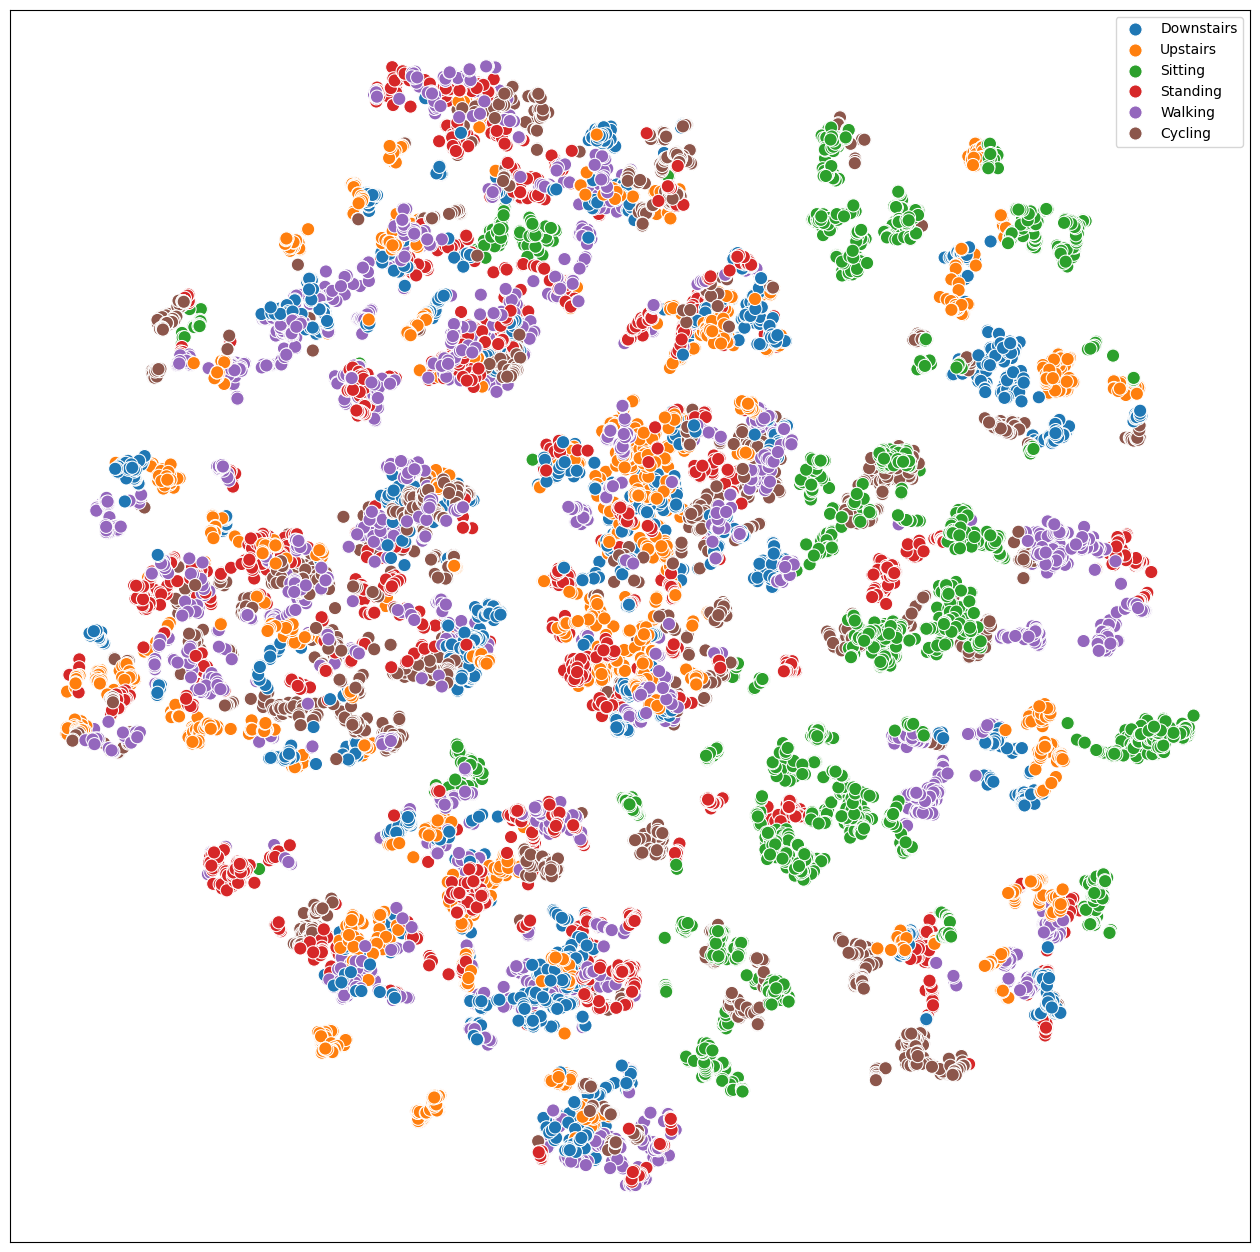

<Figure size 640x480 with 0 Axes>

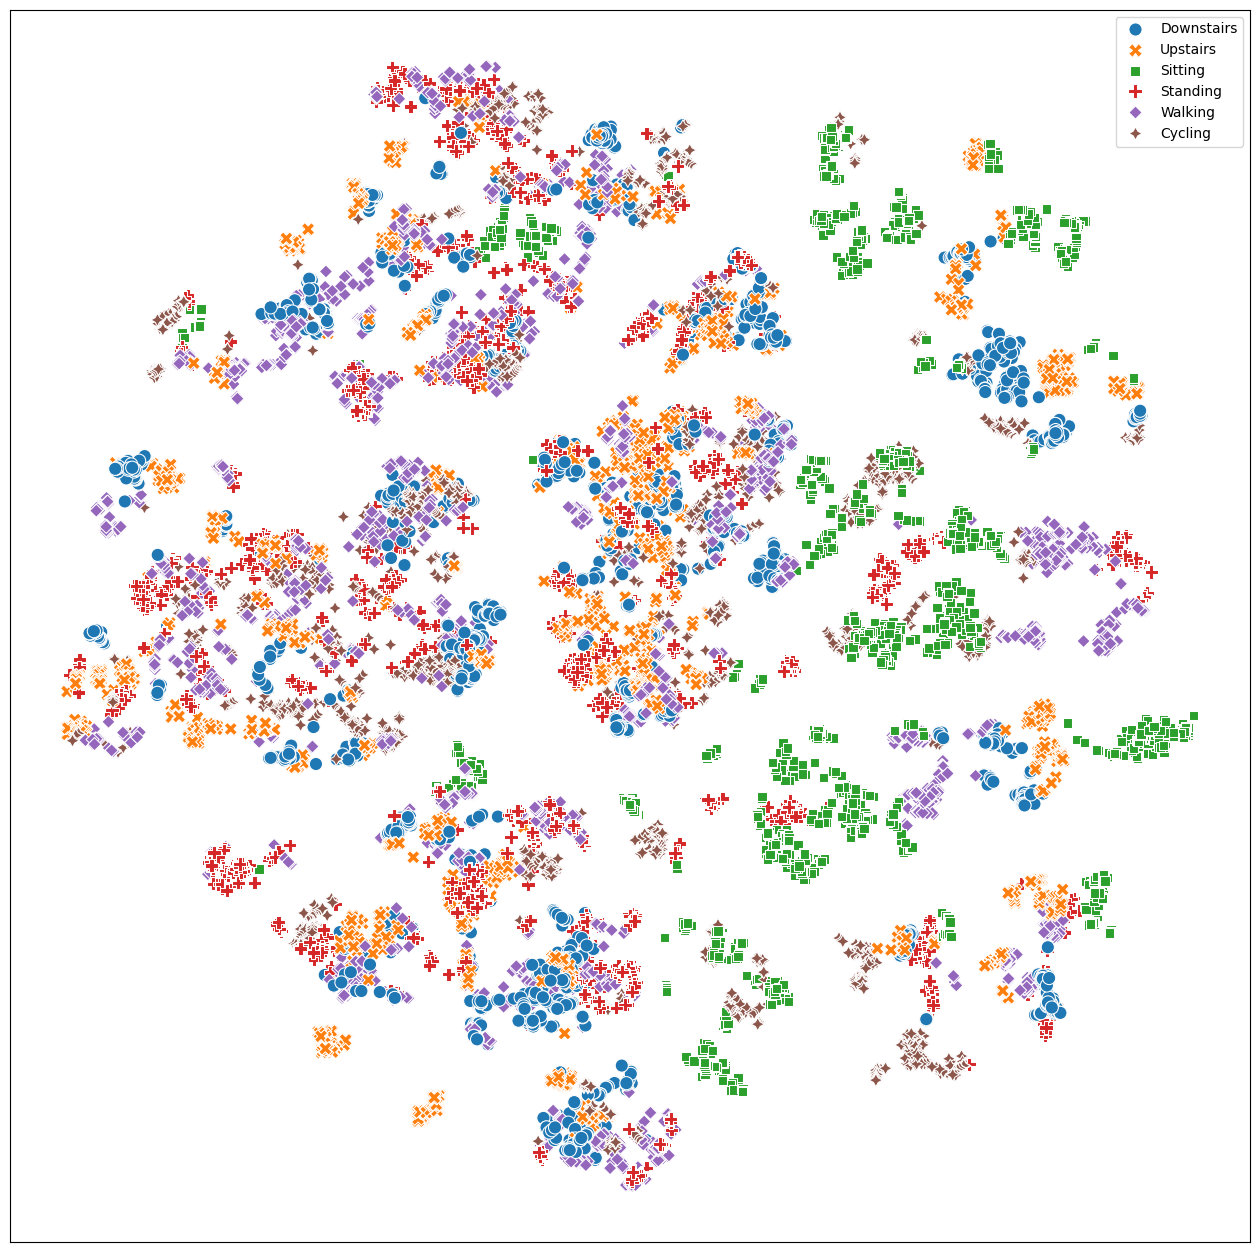

<Figure size 640x480 with 0 Axes>

In [21]:
if(not os.path.exists(trained_pipeline_weights)):
    print(trained_pipeline_weights)
    print("Not Found")
    best_val_model_callback = tf.keras.callbacks.ModelCheckpoint(val_checkpoint_pipeline_weights,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True, verbose=2)
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    pretrain_callbacks.append(best_val_model_callback)
    pretrain_callbacks.append(stop_early)
    history = pretrain_pipeline.fit(SSL_data,
                                    validation_data = (SSL_val_data,SSL_val_data), 
                                    batch_size = SSL_batch_size, 
                                    epochs = SSL_epochs,
                                    callbacks=pretrain_callbacks,
                                    verbose=2)
    
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'], label = 'Train Loss')
    plt.plot(history.history['val_loss'], label = 'Val Loss')
    plt.plot(history.history['val_loss'],markevery=[np.argmin(history.history['val_loss'])], ls="", marker="o",color="orange")
    plt.plot(history.history['loss'],markevery=[np.argmin(history.history['loss'])], ls="", marker="o",color="blue")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig(working_directory+"lossCurve.png", bbox_inches="tight")
    plt.clf()

    pretrain_pipeline.load_weights(val_checkpoint_pipeline_weights)
    pretrain_pipeline.save_weights(trained_pipeline_weights)
    pretrained_FE.save_weights(trained_FE_dir)
    perplexity = 30.0
    embeddings = pretrain_pipeline.predict(testData, batch_size=1024,verbose=0)
    tsne_model = sklearn.manifold.TSNE(perplexity=perplexity, verbose=0, random_state=42)
    tsne_projections = tsne_model.fit_transform(embeddings)
    labels_argmax = np.argmax(testLabel, axis=1)
    unique_labels = np.unique(labels_argmax)
    utils.projectTSNE('TSNE_Embeds',pretrained_dir,ALL_ACTIVITY_LABEL,labels_argmax,tsne_projections,unique_labels )
    utils.projectTSNEWithShape('TSNE_Embeds_shape',pretrained_dir,ALL_ACTIVITY_LABEL,labels_argmax,tsne_projections,unique_labels )
    hkl.dump(tsne_projections,pretrained_dir+'tsne_projections.hkl')
else:
    pretrain_pipeline.load_weights(trained_pipeline_weights)
    print("Pre-trained model found, skipping training of pretrained model",flush = True)